In [2]:
import lib.tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from lib.pinn import PINN
from lib.network import Network
from lib.optimizer import L_BFGS_B

/Users/neelarun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:

def u0(tx, c=1, k=2, sd=0.5):
    """
    Initial wave form.

    Args:
        tx: variables (t, x) as tf.Tensor.
        c: wave velocity.
        k: wave number.
        sd: standard deviation.

    Returns:
        u(t, x) as tf.Tensor.
    """

    t = tx[..., 0, None]
    x = tx[..., 1, None]
    z = k*x - (c*k)*t
    # return tf.sin(z) * tf.exp(-(0.5*z/sd)**2)
    return tf.sin(z)

def du0_dt(tx):
    """
    First derivative of t for the initial wave form.

    Args:
        tx: variables (t, x) as tf.Tensor.

    Returns:
        du(t, x)/dt as tf.Tensor.
    """

    with tf.GradientTape() as g:
        g.watch(tx)
        u = u0(tx)
    du_dt = g.batch_jacobian(u, tx)[..., 0]
    return du_dt

In [4]:
# number of training samples
num_train_samples = 10000
# number of test samples
num_test_samples = 1000
# build a core network model
network = Network.build()
network.summary()
    # build a PINN model
pinn = PINN(network).build()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# create training input
tx_eqn = np.random.rand(num_train_samples, 2)
tx_eqn[..., 0] = 4*tx_eqn[..., 0]                # t =  0 ~ +4
tx_eqn[..., 1] = 2*tx_eqn[..., 1] - 1            # x = -1 ~ +1
tx_ini = np.random.rand(num_train_samples, 2)
tx_ini[..., 0] = 0                               # t = 0
tx_ini[..., 1] = 2*tx_ini[..., 1] - 1            # x = -1 ~ +1
tx_bnd = np.random.rand(num_train_samples, 2)
tx_bnd[..., 0] = 4*tx_bnd[..., 0]                # t =  0 ~ +4
tx_bnd[..., 1] = 2*np.round(tx_bnd[..., 1]) - 1  # x = -1 or +1
# create training output
u_zero = np.zeros((num_train_samples, 1))
u_ini = u0(tf.constant(tx_ini)).numpy()
du_dt_ini = du0_dt(tf.constant(tx_ini)).numpy()

In [6]:
# train the model using L-BFGS-B algorithm
x_train = [tx_eqn, tx_ini, tx_bnd]
y_train = [u_zero, u_ini, du_dt_ini, u_zero]
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

    # predict u(t,x) distribution
t_flat = np.linspace(0, 4, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u = network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)


Optimizer: L-BFGS-B (maxiter=15000)
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1331s 89ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step


In [17]:
u.shape

(1000, 1000)

In [15]:

np.savetxt("x_1Dwave_circular.csv", x_flat, delimiter=",", header = "x")
np.savetxt("t_1Dwave_circular.csv", t_flat, delimiter=",", header = "x")
np.savetxt("u_1Dwave_circular.csv", u, delimiter=",", header = "x")

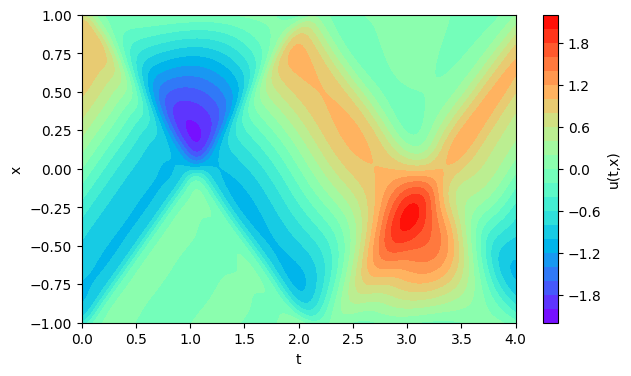

In [18]:
# with Dirichlet Boundary condition

# Plotting the function as a map
plt.figure(figsize=(7, 4))
plt.contourf(t,x,u, 20, cmap='rainbow')
plt.colorbar(label='u(t,x)')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

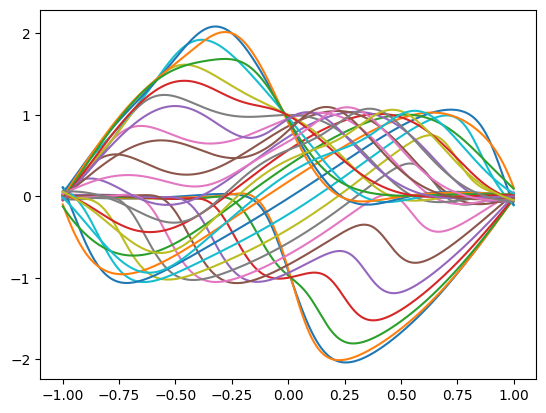

In [20]:
for var in np.arange(1, 4, 0.1):  # Loops through var = 1, 2, 3
    u = network.predict(np.stack([np.full(t_flat.shape, var), x_flat], axis=-1), batch_size=num_test_samples)
    plt.plot(x_flat, u, label=f'var={var}')  # Label each line with its var value


plt.show()

In [21]:
pip install imageio


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Create a folder to save the images
if not os.path.exists('gif_frames'):
    os.makedirs('gif_frames')

# List to store image paths for the GIF
images = []

# Loop through var = 1, 2, 3
for var in np.arange(1, 4, 0.01):
    u = network.predict(np.stack([np.full(t_flat.shape, var), x_flat], axis=-1), batch_size=num_test_samples)
    
    # Create the plot
    plt.figure()
    plt.plot(x_flat, u)
    plt.title(f'Plot for t={var}')
    plt.xlabel('x_flat')
    plt.ylabel('u')
    plt.ylim(-4, 4)
    
    # Save each frame as an image
    frame_filename = f'gif_frames/frame_{var}.png'
    plt.savefig(frame_filename)
    images.append(frame_filename)
    
    # Close the plot to avoid memory issues
    plt.close()

# Create GIF from the saved images
with imageio.get_writer('1D_output.gif', mode='I', duration=5) as writer:
    for filename in images:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup: Remove the image files if not needed
for filename in images:
    os.remove(filename)

print("GIF created as 'output.gif'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

/var/folders/qh/t3f57b9s7jv65xm86nwjv_sw0000gn/T/ipykernel_5323/3910066326.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created as 'output.gif'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


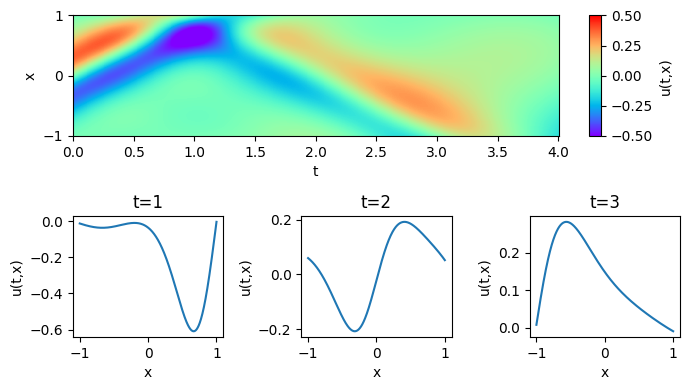

In [6]:
# with Dirichlet Boundary Conditions
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
vmin, vmax = -0.5, +0.5
plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(vmin, vmax)
t_cross_sections = [1, 2, 3]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
# plt.savefig('result_img_dirichlet.png', transparent=True)
plt.show()


TypeError: Dimensions of C (1000, 1) should be one smaller than X(1000) and Y(1000) while using shading='flat' see help(pcolormesh)

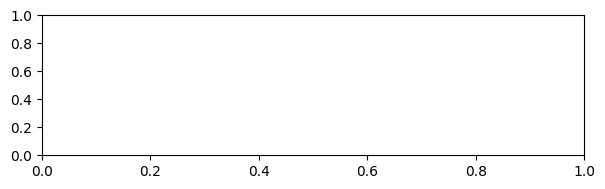

In [10]:
# with Dirichlet Boundary Conditions
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
vmin, vmax = -0.5, +0.5
plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
plt.xlabel('t')
plt.ylabel('x')
#cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(vmin, vmax)
t_cross_sections = [1, 2, 3]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
# plt.savefig('result_img_dirichlet.png', transparent=True)
plt.show()
